In [ ]:
!pip install torch torchvision

import torch
import torchvision
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib
from matplotlib import pyplot as plt


np.random.seed(1234)
torch.manual_seed(1234)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Found device : {device}")

Found device : cuda


In [ ]:
# When we load the data, they exist as as PIL images, convert to tensors, cell values are in [0, 1] so we don't need to normalize them.
transform = transforms.Compose([transforms.ToTensor()])

# load dataset
data_folder = "./fashionMNIST"
train_data = torchvision.datasets.FashionMNIST(data_folder, train=True, download=True, transform=transform)
test_data  = torchvision.datasets.FashionMNIST(data_folder, train=False, download=True, transform=transform)

# split training data into training and validation sets
train_data, valid_data = torch.utils.data.random_split(train_data, [50000,10000]) # 50k train, 10k validation

batch_size =1000
# data iterators
train_set  = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_set  = torch.utils.data.DataLoader(valid_data, shuffle=False, batch_size=batch_size)
test_set   = torch.utils.data.DataLoader(test_data,  shuffle=False, batch_size=batch_size)

100%|██████████| 26421880/26421880 [00:01<00:00, 19240487.25it/s]


Extracting ./fashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 334476.80it/s]


Extracting ./fashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6254112.51it/s]


Extracting ./fashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23393582.87it/s]

Extracting ./fashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fashionMNIST/FashionMNIST/raw



In [ ]:
# define the model

class EncoderDeep(nn.Module):
    def __init__(self, n_components):
        super(EncoderDeep, self).__init__()
        self.fc1 = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 250)
        self.fc4_mean = nn.Linear(250, n_components)
        self.fc4_std = nn.Linear(250, n_components)

    def forward(self, x):
        x = x.view(-1, 1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        mu = self.fc4_mean(x)
        std = self.fc4_std(x)
        return mu, std


class DecoderDeep(nn.Module):
    def __init__(self, n_components):
        super(DecoderDeep, self).__init__()
        self.fc1 = nn.Linear(n_components, 250)
        self.fc2 = nn.Linear(250, 500)
        self.fc3 = nn.Linear(500, 1000)
        self.fc4 = nn.Linear(1000, 784)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x)) # self.fc4(x)#
        x = x.view(-1, 1, 28, 28)
        return x


def reparameterize(mu, std):
    """
    Take in mean and log(standard deviation) of a Normal distribution,
    and output a n_samples from the corresponding gaussian.
    """
    z_samples = torch.randn_like(mu)
    rep_samples = std*z_samples + mu
    return rep_samples

In [ ]:
# training stuff
n_components = 2 # 2 dimensional latent space
encoder = EncoderDeep(n_components=n_components)
decoder = DecoderDeep(n_components=n_components)

encoder = encoder.cuda()
decoder = decoder.cuda()

params = list(encoder.parameters()) + list(decoder.parameters())

optimizer = torch.optim.Adam(params=params, lr=1e-3)

criterion = nn.BCELoss(reduction='sum')


In [ ]:
n_epochs = 10

encoder.train()
decoder.train()

kl_losses    = []
recon_losses = []
elbo         = []
for epoch in range(n_epochs):
    kl_  = []
    rec_ = []
    elbo_= []
    for data, label in train_set:
        data = data.cuda()
        optimizer.zero_grad()

        z_means, z_stds = encoder(data)
        z_stds = torch.exp(z_stds)

        z = reparameterize(z_means, z_stds)
        x = decoder(z)
        loss_reconstruction = criterion(x, data)/batch_size

        # https://ai.stackexchange.com/questions/26366/how-is-this-pytorch-expression-equivalent-to-the-kl-divergence
        loss_kl = -torch.mean(0.5*torch.sum(1 - torch.pow(z_stds,2) - torch.pow(z_means,2) + torch.log(torch.pow(z_stds,2)), dim=-1))

        loss = loss_reconstruction + loss_kl

        loss.backward()
        optimizer.step()

        kl_.append(loss_kl.item())
        rec_.append(loss_reconstruction.item())
        elbo_.append(loss.item())

    kl_losses.append(np.mean(kl_))
    recon_losses.append(np.mean(rec_))
    elbo.append(np.mean(elbo_))
    print("Epoch {:3d}  Reconstruction Loss {:7>.7f} KL loss {:7>.7f}, ELBO {:7>.7f}".format(epoch, recon_losses[-1], kl_losses[-1], elbo[-1]))

Epoch   0  Reconstruction Loss 256.4598651 KL loss 6.2180626, ELBO 262.6779297
Epoch   1  Reconstruction Loss 256.0702426 KL loss 6.2129683, ELBO 262.2832111
Epoch   2  Reconstruction Loss 255.3196884 KL loss 6.2506540, ELBO 261.5703424
Epoch   3  Reconstruction Loss 254.9879373 KL loss 6.2486170, ELBO 261.2365527
Epoch   4  Reconstruction Loss 254.2578012 KL loss 6.2914442, ELBO 260.5492459
Epoch   5  Reconstruction Loss 253.5597424 KL loss 6.3155072, ELBO 259.8752484
Epoch   6  Reconstruction Loss 253.5044666 KL loss 6.3015107, ELBO 259.8059793
Epoch   7  Reconstruction Loss 252.9354999 KL loss 6.3393628, ELBO 259.2748624
Epoch   8  Reconstruction Loss 252.7111584 KL loss 6.3459862, ELBO 259.0571451
Epoch   9  Reconstruction Loss 252.3486438 KL loss 6.3703277, ELBO 258.7189719


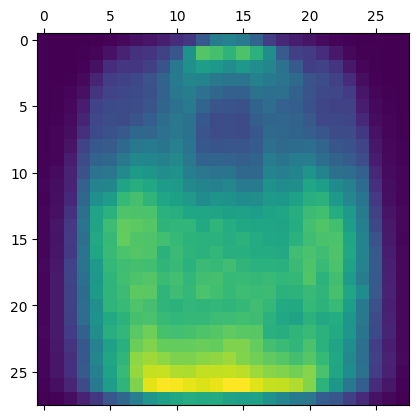

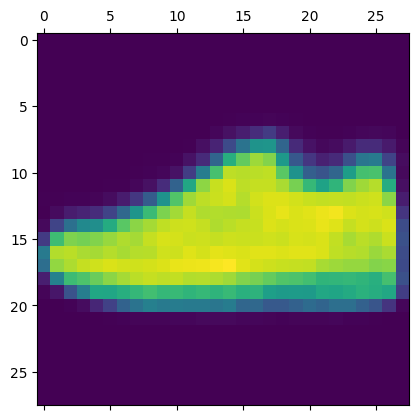

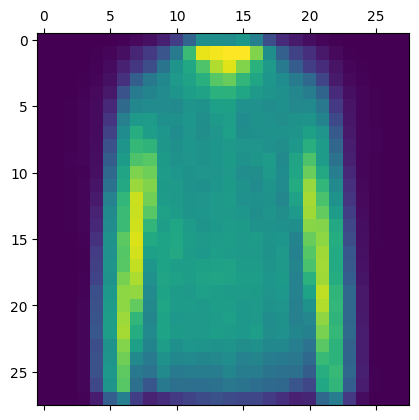

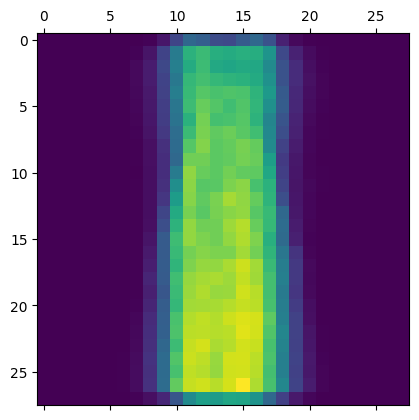

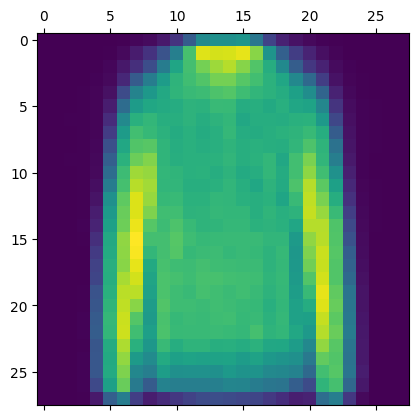

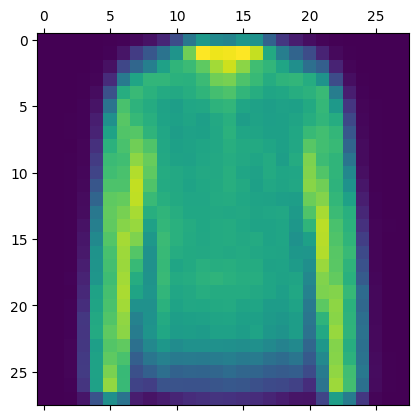

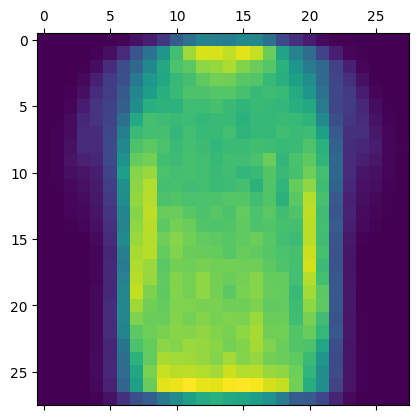

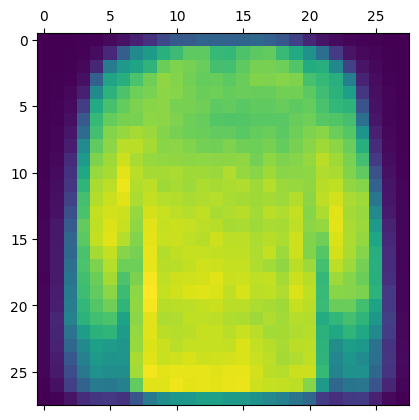

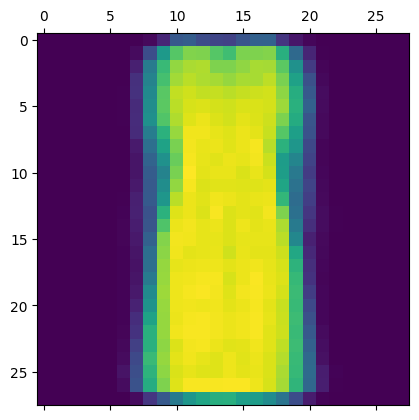

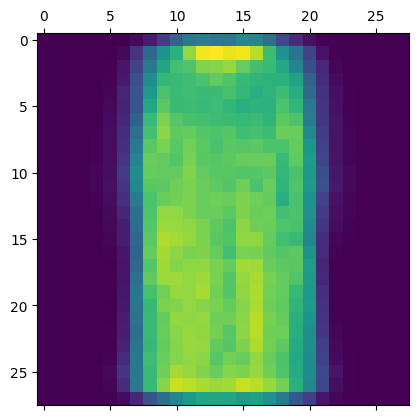

In [ ]:
for i in range(10):
    plt.matshow(x[i].detach().cpu().numpy().reshape(28,28))

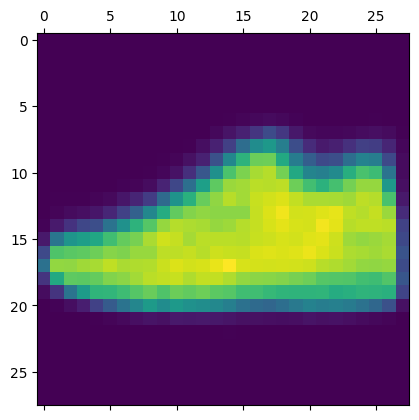

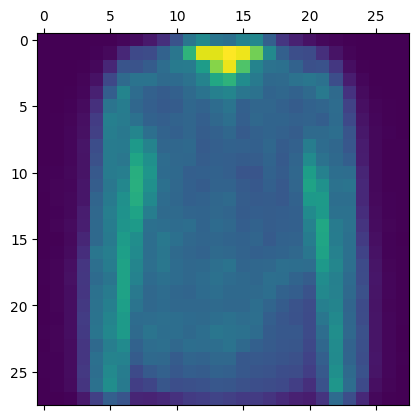

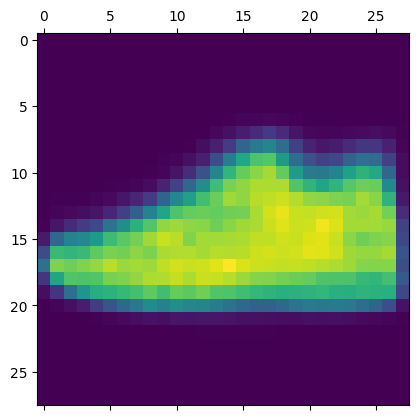

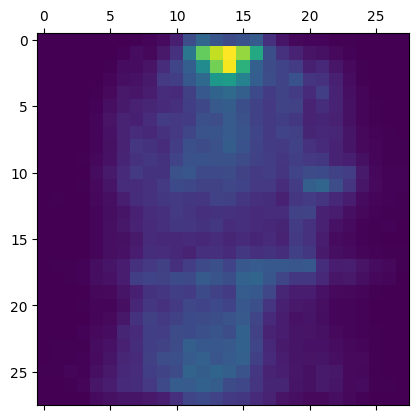

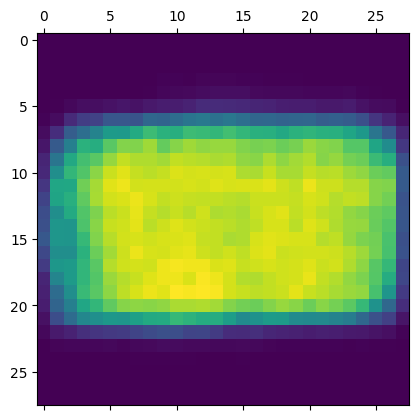

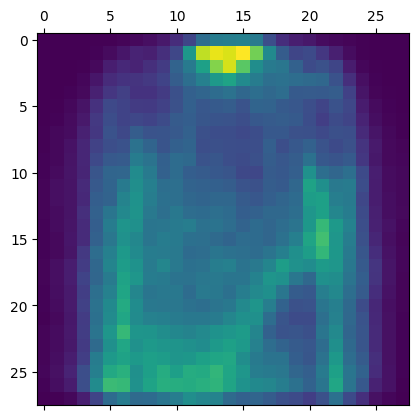

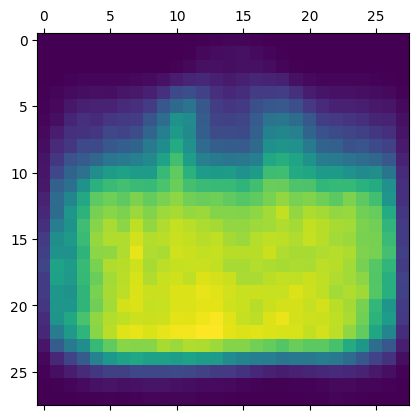

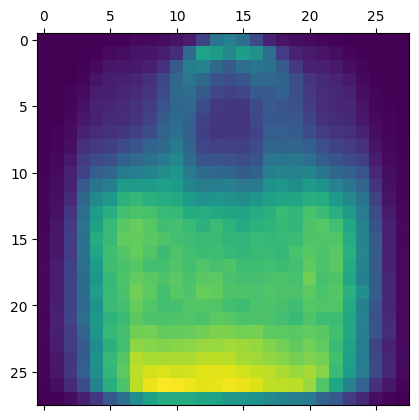

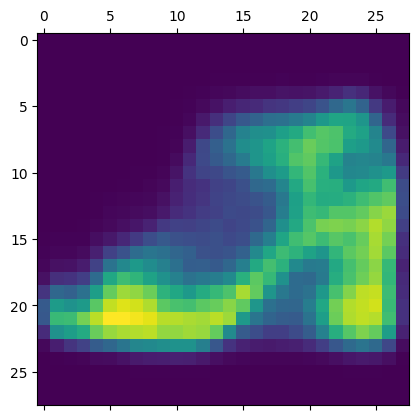

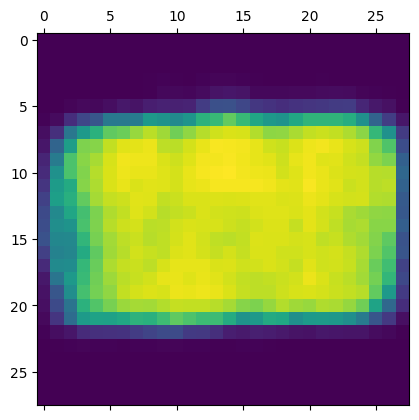

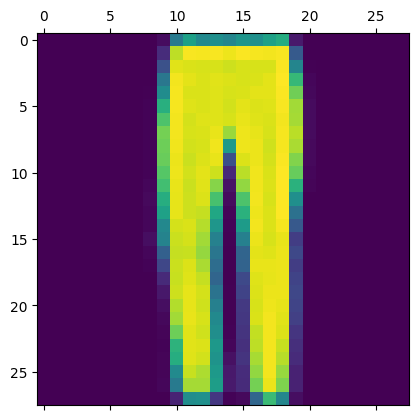

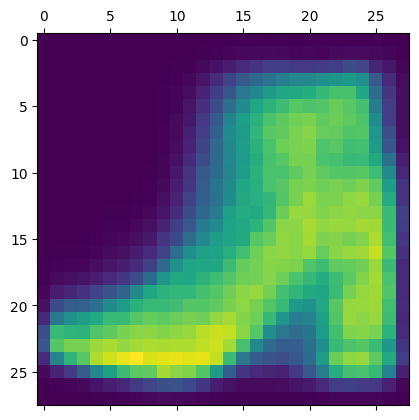

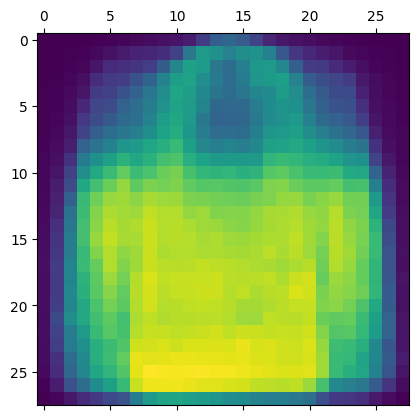

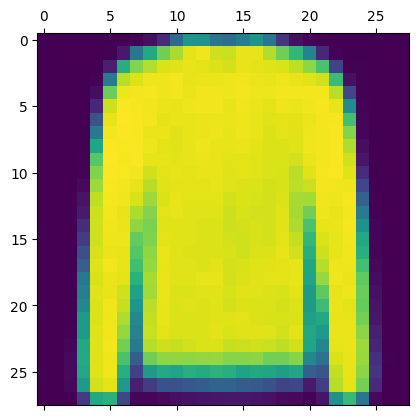

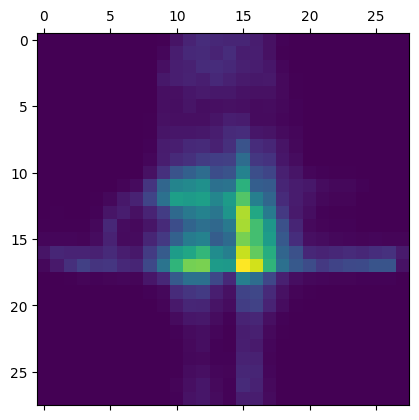

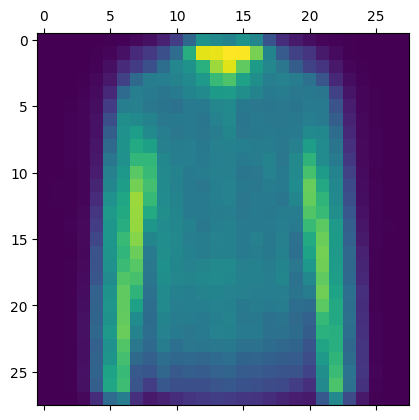

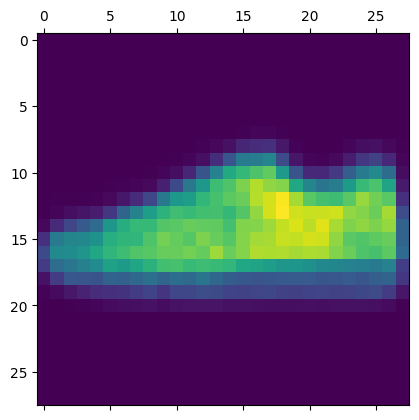

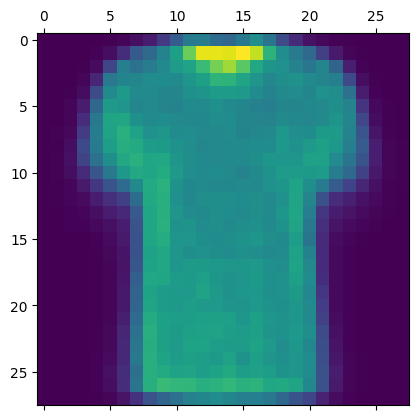

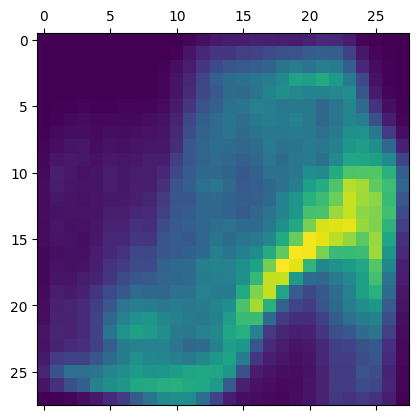

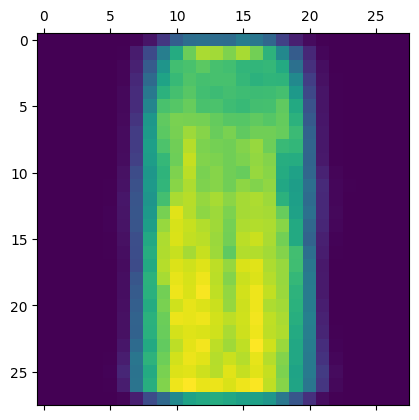

In [ ]:
z_new = torch.randn_like(z_means)
x_new = decoder(z_new)
for i in range(20):
    plt.matshow(x_new[i].detach().cpu().numpy().reshape(28,28))


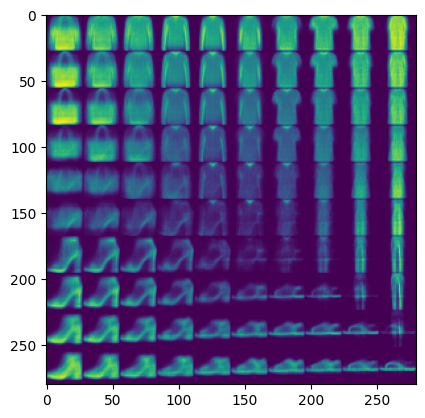

In [ ]:
x = np.linspace(-1,1,10)
y = np.linspace(-1,1,10)
X,Y = np.meshgrid(x,y)
z_grid = np.hstack((X.reshape(100,1), Y.reshape(100,1)))
z_grid = torch.from_numpy(z_grid).float()
z_grid = z_grid

new_decoder = decoder.cpu()
x_new = new_decoder(z_grid)

def convert_to_oneimage(x_new):
    """
    x_new is assumed to be n_row**2, 1, width, height
    concretely, (100, 1, 28, 28) so 100 images of 28,28
    """
    n_rows = int(np.sqrt(x_new.shape[0]))
    w,h = x_new.shape[2], x_new.shape[3]
    new_img = np.zeros((n_rows*w, n_rows*h))

    for row in range(n_rows):
        for col in range(n_rows):
            new_img[row*w:row*w+w,col*h:col*h+h] = x_new[row*n_rows+col].reshape(w,h)
    plt.imshow(new_img)

convert_to_oneimage(x_new.detach().numpy())